# Combinatorial Optimization - Labolatories

### Artificial Intelligence 2021 sem. 3

### Labolatories

### Library Book Assignment

### Kacper Trębacz 145453

### Jan Gruszczyński 145464

## Requirements 
python version 3.7.6

numpy 1.18.5

ortools Version: 8.1.8487

# Implementation

Note: in this notebook program read from list of files to show scores on the example input files. Program itself read from standard input.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from math import sqrt
import copy

# Max flow Max cost solver
from ortools.graph import pywrapgraph

### Library class definition
Every library has it's id, size, signup_time, books_per_day (how many libraries a day it can scan) and a set of book_ids. We choose a set to efficiently remove previously choosen books.

In [2]:
class Library:
    def __init__(self, index, N, T, M):
        self.id = index
        self.size = N
        self.signup_time = T
        self.books_per_day = M
        self.book_ids = set()

    def add_book(self, book):
        self.book_ids.add(book)

    def remove_book(self, book):
        self.book_ids.remove(book)

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

### Reading a file
Except from reading book values and library data with book assignments, we also have a table with sets of library_ids for every book. So to store data in how many libraries given book is stored, thus allowing us to quickly update it in our greedy interval solver.

In [3]:
# Loads data from files into the class Library Objects
def process_file(filePath):
    with open('../data/'+filePath, 'r') as file:
        content = file.read().split('\n')[:-1]
        B, L, D = content[0].split()
        B, L, D = int(B), int(L), int(D)

    book_libraries = [set() for i in range(0, B)]
    book_values = [int(n) for n in content[1].split()]
    libraries = []

    for i in range(L):
        N, T, M = content[2 + 2 * i].split()
        N, T, M = int(N), int(T), int(M)
        book_ids = set(int(id_) for id_ in content[2 + 2 * i + 1].split())
        library = Library(i, N, T, M)

        for book_id in book_ids:
            book_libraries[book_id].add(i)
            library.add_book(book_id)
        libraries.append(library)
    return (B, L, D), book_values, book_libraries, libraries

### Terminology
individual - a tuple of ordered ids

solution - a list of libraries with correctly assigned books

### Scoring
Scoring function simply sums up scores fo books in every library.

In [4]:
def score_solution(libraries, book_values):
    score = 0
    for library in libraries:
        for book_id in library.book_ids:
            score += book_values[book_id]
    return score

### Check function
this function checks if generated solution is valid:
* no duplicates of libraries
* no book duplicates in library
* if the number of books is correct
* if no library is signuped up after the deadline

In [5]:
def check_solution(D, libraries):
    days = 0
    prev_books = set()
    lib_ids = [lib.id for lib in libraries]
    # checking if there are no duplicates of libraries in the solution
    assert (len(lib_ids) == len(set(lib_ids)))

    for library in libraries:
        days += library.signup_time

        # checking if library sends correct number of books
        if len(library.book_ids) > (D - days) * library.books_per_day:
            print("Library sends more books, than it is allowed to:", len(library.book_ids),
                  (D - days) * library.books_per_day)

        # checking if there is no repetition of books
        assert (len(library.book_ids) == len(set(library.book_ids)))
        assert (not any([(book in prev_books) for book in library.book_ids]))
        prev_books.update(library.book_ids)

    # checking if we do not go over the deadline
    assert (days < D)

In [6]:
def save_solution_to_file(solution, file_path, flag=False):
    lines = [str(len(solution)) + "\n"]
    for library in solution:
        lines.append(f"{str(library.id)} {len(library.book_ids)}\n")
        aString = ""
        for book_id in library.book_ids:
            aString += f"{str(book_id)} "
        aString = aString.strip() + "\n"
        lines.append(aString)
    if flag:
        with open(file_path, "w+") as file:
            file.flush()
            file.writelines(lines)
    else:
        with open(f"{str(file_path[:-4])}_solution.txt", "w+") as file:
            file.flush()
            file.writelines(lines)

### Problem Solver
It is an abstract class of almost every solver that we use. It has an already defined get_solution function which transforms individual into a solution. It does so by assigning the best books from library that had not been chosen before.

In [7]:
class ProblemSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B, L, D
        self.book_values = book_values
        self.libraries = libraries
        self.book_libraries = copy.deepcopy(book_libraries)

    def book_score(self, book):
        return self.book_values[book]

    def get_n_best_books(self, lib, n):
        return sorted(lib.book_ids, key=self.book_score, reverse=True)[:n]

    def get_solution(self, selected_lib_ids=None):
        if not selected_lib_ids:
            selected_lib_ids = self.get_individual()
        day = 0
        selected_libraries = [copy.deepcopy(self.libraries[i]) for i in selected_lib_ids]
        it = 0
        already_scanned_books = set()
        while it < len(selected_libraries):
            next_library = selected_libraries[it]
            day += next_library.signup_time
            if day >= self.D:
                break
            next_library.book_ids = next_library.book_ids - already_scanned_books
            next_library.book_ids = sorted(next_library.book_ids, key=self.book_score, reverse=True)[
                                    :(self.D - day) * next_library.books_per_day]
            already_scanned_books.update(next_library.book_ids)
            it += 1
        return selected_libraries[:it]

    def get_individual(self):
        pass

### Heurystic Solver
An abstract class that defines a way that every heurystic solver creates an individual. It does so by sorting libraries according to its heurystics and by choosing best one (library) till we have reached the deadline. Default heuristic function is f = S/signup_time
#### Terminology for heurystic solvers
* S - sum of best books
* signup_time - library signup time
* var(S) - variance of S
* book_score - book score 
* book_libraries - number of libraries that have a book
* D number of days
*n length of N best books

In [8]:
class HeuristicSolver(ProblemSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time

    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        lib_ids.sort(key=self.library_score, reverse=True)
        day = 0
        chosen = []
        for i in range(len(lib_ids)):
            if day + self.libraries[lib_ids[i]].signup_time >= self.D:
                continue
            day += self.libraries[lib_ids[i]].signup_time
            chosen.append(lib_ids[i])
        return tuple(chosen)

### Power Solver
Heurystic solver with a given function f = S/(signup_time)^(1+signup_time/D) 

In [9]:
class PowerSolver(HeuristicSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time ** (1 + lib.signup_time / self.D)

### SimpleScoreVarianceSolver
Heurystic solver with a given function f = S/var(S)

In [10]:
class SimpleScoreVarianceSolver(HeuristicSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001, np.var(best_scores))
        return sum_of_best_book_scores / book_variance

### SquareScoreVarianceSolver
Heurystic solver with a given function f = (S^2)/(signup_time^2 * sqrt(var(S))

In [11]:
class SquareScoreVarianceSolver(HeuristicSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001, np.var(best_scores))
        return sum_of_best_book_scores ** 2 / (lib.signup_time * lib.signup_time * sqrt(book_variance))

### BookNumbersSolver
Heurystic solver with a given function f = S^2/(var(S)*n*signup_time) 

In [12]:
class BookNumbersSolver(HeuristicSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        best_scores = [self.book_values[book] for book in n_best_books]
        sum_of_best_book_scores = sum(best_scores)
        book_variance = max(0.001, np.var(best_scores))
        return sum_of_best_book_scores ** 2 / (book_variance * len(n_best_books) * lib.signup_time)

### ScoreSquareSolver
Heurystic solver with a given function f = S^2/(signup_time)

In [13]:
class ScoreSquareSolver(HeuristicSolver):
    def library_score(self, lib_id):
        lib = self.libraries[lib_id]
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores ** 2 / lib.signup_time

### BookCountSolver
Heurystic solver with a book score function = book_value-length(book_libraries) 

In [14]:
class BookCountSolver(HeuristicSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7 * len(self.book_libraries[book])

### BookCountPowerSolver
Power solver with a book score function = book_value-length(book_libraries) 

In [15]:
class BookCountPowerSolver(PowerSolver):
    def book_score(self, book):
        return self.book_values[book] - 0.7 * len(self.book_libraries[book])

### RandomSolver
Shuffles library ids and selects them till it reaches the deadline.

In [16]:
class RandomSolver(ProblemSolver):
    def get_individual(self):
        lib_ids = [i for i in range(len(self.libraries))]
        random.shuffle(lib_ids)
        day = 0
        for i in range(len(lib_ids)):
            day += self.libraries[lib_ids[i]].signup_time
            if day >= self.D:
                return tuple(lib_ids[:i])
        return tuple(lib_ids)

### GreedyIntervalSolver
Essentially a BookCountSolver. However it sorts libraries repeatedly every 25th iteration. Due to the fact that it needs to create a complete solution while creating individual, it does not inherit from Problem Solver. Instead it implements a method get_individual_from_solution, which returns an individual from solution.

In [17]:
class GreedyIntervalSolver:
    def __init__(self, B, L, D, book_values, book_libraries, libraries):
        self.B, self.L, self.D = B, L, D
        self.book_values = book_values
        self.libraries = copy.deepcopy(libraries)
        self.book_libraries = copy.deepcopy(book_libraries)

    def book_score(self, book_id):
        return self.book_values[book_id] - 0.7 * len(self.book_libraries[book_id])

    def get_n_best_books(self, lib, n):
        return sorted(lib.book_ids, key=self.book_score, reverse=True)[:n]

    def library_score(self, lib_id, current_day):
        lib = self.libraries[lib_id]
        delta_time = self.D - current_day - lib.signup_time
        n_best_books = self.get_n_best_books(lib, min(delta_time * lib.books_per_day, len(lib.book_ids)))
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        sum_of_best_book_scores /= lib.signup_time
        return sum_of_best_book_scores

    def get_solution(self):
        remaining_libraries = set(lib.id for lib in self.libraries)
        day = 0
        chosen_libraries = []
        it = 0
        interval = 25
        while len(remaining_libraries) > 0:
            if it % interval == 0:
                library_scores = [(self.library_score(lib_id, day), lib_id) for lib_id in remaining_libraries]
            it += 1
            max_el = max(library_scores, key=lambda x: x[0])
            library_scores.remove(max_el)
            score, lib_id = max_el
            remaining_libraries.remove(lib_id)
            library = self.libraries[lib_id]
            if day + library.signup_time >= self.D:
                break
            day += library.signup_time
            books_to_take = (self.D - day) * library.books_per_day
            sorted_books = sorted(library.book_ids, key=self.book_score, reverse=True)
            for book_id in sorted_books[:books_to_take]:
                for lib_id in self.book_libraries[book_id]:
                    if lib_id != library.id:
                        self.libraries[lib_id].remove_book(book_id)

            for book_id in sorted_books[books_to_take:]:
                self.book_libraries[book_id].remove(library.id)

            library.book_ids = sorted_books[:books_to_take]
            chosen_libraries.append(library)
        return chosen_libraries

    def get_individual_from_solution(self, solution):
        return tuple([lib.id for lib in solution])

### GeneticSolver
It is a problem solver that implements a genetic method. The solver stores scores fo all individuals in a dictionary, so if individuals are duplicatedm it does not need to recalulate  the individual's score. This algorithm generates its initial population using all previous solvers. Then it calculates their scores and performs the following operations till it runs out of time.
* create a new population
* preserve a defined percentage of population by selecting them by means of a tournament, those which win are added to a new population
* while new population size is smaller than defined value, it performs the following steps:
* * with propability of 50% it either mutates  individuals or performs a simulation of genetic cross-over.
* *  then newly created individuals are added back to the new population
After running of time we select the best individual and return it.

#### Muation
The mutation works in 2 ways with 50% probaility each.
* local mutation - 4 swaps of 2 random libraries
* external mutation - selects 4 random libraries with probability equal to it'ss score. Than it inserts them at random places in the gene.
Cut operation is performed if the gene of an newly created individual is too long.

#### Crossover
First we select common and different ids from two selected individuals. Then we create children by taking indexes of common ids from one parent and placing "different ids" from second parent at places where previously were positioned "different ids" from the first parent.

Example:

parent1: 12453

parent2: 36172

child1: 12673

child2: 34152

In [18]:
class GeneticSolver(ProblemSolver):
    def __init__(self, B, L, D, book_values, book_libraries, libraries,start_time, deadline = 240,pop_size=20, p_mutate=0.5, surv_rate=0.2,
                 tournament_size=3):
        super().__init__(B, L, D, book_values, book_libraries, libraries)
        num = 1
        length_of_libraries = len(libraries)
        while num < pop_size and length_of_libraries != 1:
            num *= length_of_libraries
            length_of_libraries -= 1
        self.pop_size = min(pop_size, num)
        self.p_mutate = p_mutate
        self.tournament_size = min(self.pop_size, tournament_size)
        self.survival_rate = surv_rate
        self.book_values = book_values
        self.individual_scores = dict()
        self.lib_ids = [i for i in range(len(libraries))]
        self.lib_scores = [self.lib_score(lib) for lib in self.libraries]
        self.start_time = start_time
        self.deadline = deadline

    def lib_score(self, lib):
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time

    def mutate(self, individual):
        new_one = list(individual)
        if random.random() <= 0.5:
            # internal mutation
            length = len(new_one)
            for i in range(4):
                a, b = random.sample(range(length), 2)
                new_one[a], new_one[b] = new_one[b], new_one[a]
            return tuple(individual)
        else:
            # external mutation
            additional = random.choices(self.lib_ids, k=4, weights=self.lib_scores)
            unique = set(additional)
            for un in unique:
                new_one.insert(random.randrange(0, len(new_one)), un)
            return self.cut(new_one)

    def cut(self, new_one):
        day = 0
        chosen = set()
        solution = []
        for i in range(len(new_one)):
            if new_one[i] not in chosen:
                day += self.libraries[new_one[i]].signup_time
                if day >= self.D:
                    continue
                solution.append(new_one[i])
                chosen.add(new_one[i])
        return tuple(solution)

    def crossover(self, indiv_1, indiv_2):
        set1 = set(indiv_1)
        set2 = set(indiv_2)
        common = set1.intersection(set2)
        max_length = max(len(indiv_1), len(indiv_2))
        child1, child2, = [-1] * max_length, [-1] * max_length
        only1, only2 = [], []
        for i in range(len(indiv_1)):
            if indiv_1[i] in common:
                child1[i] = indiv_1[i]
            else:
                only1.append(indiv_1[i])
        for i in range(len(indiv_2)):
            if indiv_2[i] in common:
                child2[i] = indiv_2[i]
            else:
                only2.append(indiv_2[i])
        for i in range(max_length):
            if child1[i] == -1 and len(only2) > 0:
                child1[i] = only2.pop(0)
            if child2[i] == -1 and len(only1) > 0:
                child2[i] = only1.pop(0)
        child1 = [i for i in child1 if i != -1]
        child2 = [i for i in child2 if i != -1]

        child1 = self.cut(child1)
        child2 = self.cut(child2)
        if random.random() <= self.p_mutate:
            child1 = self.mutate(child1)
        if random.random() <= self.p_mutate:
            child2 = self.mutate(child2)
        return child1, child2

    def tournament(self, indivs):
        return max(indivs, key=self.individual_scores.get)

    def get_initial_population(self):
        solvers_cls = [HeuristicSolver, PowerSolver, SimpleScoreVarianceSolver, SquareScoreVarianceSolver,
                       BookNumbersSolver, ScoreSquareSolver, BookCountSolver, BookCountPowerSolver]
        solvers = [cl(self.B, self.L, self.D, self.book_values, self.book_libraries, self.libraries) for cl in
                   solvers_cls]
        population = [solver.get_individual() for solver in solvers]
        greedyIntervalSolver = GreedyIntervalSolver(self.B, self.L, self.D, self.book_values, self.book_libraries,
                                                    self.libraries)
        greedyIntervalSolution = greedyIntervalSolver.get_solution()
        gis_individual = greedyIntervalSolver.get_individual_from_solution(greedyIntervalSolution)
        population.append(gis_individual)
        self.individual_scores[gis_individual] = score_solution(greedyIntervalSolution, self.book_values)
        print("Greedy interval score: ", self.individual_scores[gis_individual],"time:", time.time()-self.start_time)
        randomSolver = RandomSolver(self.B, self.L, self.D, self.book_values, self.book_libraries, self.libraries)
        while len(population) < self.pop_size:
            population.append(randomSolver.get_individual())
        return population

    def get_individual(self):
        population = self.get_initial_population()
        for indiv in population:
            sol = self.get_solution(indiv)
            self.individual_scores[indiv] = score_solution(sol, self.book_values)
        progress = []
        times = []
        while True:
            progress.append(max(self.individual_scores.values()))
            times.append(time.time() - self.start_time)
            if time.time() - self.start_time > self.deadline:
                break
            new_population = [self.tournament(random.sample(population, self.tournament_size)) for i in
                              range(int(self.pop_size * self.survival_rate))]
            while len(new_population) < self.pop_size:
                individual_1 = self.tournament(random.sample(population, self.tournament_size))
                individual_2 = self.tournament(random.sample(population, self.tournament_size))
                if random.random() <= 0.5:
                    new_child1 = self.mutate(individual_1)
                    new_child2 = self.mutate(individual_2)
                else:
                    new_child1, new_child2 = self.crossover(individual_1, individual_2)
                if new_child1 not in self.individual_scores:
                    self.individual_scores[new_child1] = score_solution(self.get_solution(new_child1), self.book_values)
                if new_child2 not in self.individual_scores:
                    self.individual_scores[new_child2] = score_solution(self.get_solution(new_child2), self.book_values)
                new_population.append(new_child1)
                new_population.append(new_child2)
            population = tuple(new_population)
        min_ = min(progress)
        plt.title("Progress of score from: " + str(min_) + " to " + str(max(progress)))
        plt.plot(times, progress, color="blue", label="Progress", alpha=0.5, linewidth=2)
        plt.plot(times, [min_ for x in range(0, len(times))], linestyle="--", linewidth=1, color="red",
                 label="Base level", alpha=0.5)
        plt.xlabel("time [s]")
        plt.ylabel("score [-]")
        plt.legend()
        plt.show()
        print("Genetic Progress:", max(progress) - min_)
        print("Score from GA:", max(progress))
        return max(self.individual_scores, key=self.individual_scores.get)

### MutationHillClimbingSolver
After receiving the result from GeneticSolver it performs a sort of "randomized hill climbing". Hill climber performs the very same mutations as in GeneticSolver. Using these mutations it creates a neighbourhood of a size 10, and then  it selects the best individual. If selected individual is better than current best individual it becomes our (current best) individual.

In [19]:
class MutationHillClimbingSolver(ProblemSolver):
    def __init__(self, B, L, D, book_values, book_libraries, libraries, individual_scores,start_time, deadline = 260, neighbourhood_size=10):
        super().__init__(B, L, D, book_values, book_libraries, libraries)
        self.neighbourhood_size = neighbourhood_size
        self.individual_scores = individual_scores
        self.lib_ids = [i for i in range(len(libraries))]
        self.lib_scores = [self.lib_score(lib) for lib in self.libraries]
        self.deadline = deadline
        self.start_time = start_time

    def lib_score(self, lib):
        delta_time = self.D - lib.signup_time
        n_best_books = self.get_n_best_books(lib, delta_time * lib.books_per_day)
        sum_of_best_book_scores = sum([self.book_values[book] for book in n_best_books])
        return sum_of_best_book_scores / lib.signup_time

    def mutate(self, individual):
        new_one = list(individual)
        if random.random() <= 0.5:
            # internal mutation
            length = len(new_one)
            for i in range(4):
                a, b = random.sample(range(length), 2)
                new_one[a], new_one[b] = new_one[b], new_one[a]
            return tuple(individual)
        else:
            # external mutation
            additional = random.choices(self.lib_ids, k=4, weights=self.lib_scores)
            unique = set(additional)
            for un in unique:
                new_one.insert(random.randrange(0, len(new_one)), un)
            return self.cut(new_one)

    def cut(self, new_one):
        day = 0
        chosen = set()
        solution = []
        for i in range(len(new_one)):
            if new_one[i] not in chosen:
                day += self.libraries[new_one[i]].signup_time
                if day >= self.D:
                    continue
                solution.append(new_one[i])
                chosen.add(new_one[i])
        return tuple(solution)

    def get_individual(self, start_individual):
        cur_best = copy.copy(start_individual)
        cur_best_score = self.individual_scores[cur_best]
        progress = [cur_best_score]
        while time.time() - self.start_time < self.deadline:
            neighbourhood = []
            n_scores = []
            for i in range(self.neighbourhood_size):
                new_one = self.mutate(cur_best)
                if new_one not in self.individual_scores:
                    new_solution = self.get_solution(new_one)
                    new_score = score_solution(new_solution, self.book_values)
                    self.individual_scores[new_one] = new_score
                else:
                    new_score = self.individual_scores[new_one]
                neighbourhood.append(new_one)
                n_scores.append(new_score)
            new_max_score = max(n_scores)
            new_max_score_index = n_scores.index(new_max_score)
            if new_max_score > cur_best_score:
                cur_best = neighbourhood[new_max_score_index]
                cur_best_score = new_max_score
            progress.append(cur_best_score)
        print("Climber progress:", max(progress)-self.individual_scores[start_individual])
        return cur_best

### Max Flow Max Cost
After the MutationHillClimbingSolver returns an individual (generated by the genetic solver) we are trying to optimize book to library assignment for a given library ordering. To do that, we firstly use google ortools to solve first max flow, then max cost problem. To do so, we are create a flow graph. It will consists of source vertex(node). For each library we are going to create a node that connects it to a source with an edge with flow = (D-day_when_lib_signup_completed)*books_per_day and cost = 0. For each book we create a node, the node is connected to every library that has given book, with edge with flow = 1 and cost = 0. There is also an edge from book nodes to a sink with flow =1 and cost = -book_value. (we are using -book_value, because our solver solves min cost problem, so in that way we trick the algorithm into selecting the books with the highest value.


First we are going to use max_flow solver from ortools to find what is the maximum number of books that can be scanned by all libraries. Then we can use that flow as a value of flow for source node (with + sign0 and for sink node (with - sign). Then we can use min cost solver from ortools, that really solves transportation problem (but assigning flow value to just a sink and source makes it just a min cost problem), to see which books are going to give us the highest score.

##### Note: 
We can use max flow (and not anything smaller), because in our graph there are no edges with cost of different sign (+,-), so no book has a negative effect. It is also due to the fact that edges to and from books have unit flow.

In [20]:
#max flow functions
def generate_book_to_node_assignment(number_of_libraries, all_book_ids):
    book_to_node = dict()
    node_to_book = dict()
    counter = 1
    for book_id in all_book_ids:
        node_nr = number_of_libraries + counter
        book_to_node[book_id] = node_nr
        node_to_book[node_nr] = book_id
        counter += 1
    return book_to_node, node_to_book


def lib_to_node(lib_id):
    return lib_id + 1


def node_to_lib(node):
    return node - 1

In [21]:
def solve_one_example_with_genetic_climber_max_flow(file_path, file_to, deadline_for_genetic, deadline_for_hill_climber,
                                                    flag=True):
    start_time = time.time()
    print("File:", str(file_path))
    (B, L, D), book_values, book_counts, libraries = process_file(file_path)
    libraries_backup = copy.deepcopy(libraries)
    genetic_solver = GeneticSolver(B, L, D, book_values, book_counts, libraries, start_time,
                                   deadline=deadline_for_genetic)
    individual = genetic_solver.get_individual()
    check_solution(D, genetic_solver.get_solution(selected_lib_ids=individual))
    score_from_genetic = score_solution(genetic_solver.get_solution(selected_lib_ids=individual), book_values)

    hill_climber_solver = MutationHillClimbingSolver(B, L, D, book_values, book_counts, libraries,
                                                     genetic_solver.individual_scores,start_time,
                                                     deadline=deadline_for_hill_climber)
    # Creating new individual with hill_climber
    individual = hill_climber_solver.get_individual(individual)
    climbed_solution = hill_climber_solver.get_solution(individual)
    check_solution(D, climbed_solution)
    climbed_score = score_solution(climbed_solution, book_values)
    print("Score after climbing:", climbed_score)

    libraries = libraries_backup

    all_book_ids = set()
    for lib_id in individual:
        all_book_ids.update(libraries[lib_id].book_ids)
    book_to_node, node_to_book = generate_book_to_node_assignment(len(individual), all_book_ids)

    start_nodes = []
    end_nodes = []
    capacities = []
    unit_costs = []

    source = 0
    sink = len(individual) + len(all_book_ids) + 1
    day = 0

    # from source to lib
    for i in range(len(individual)):
        day += libraries[individual[i]].signup_time
        start_nodes.append(source)
        end_nodes.append(lib_to_node(i))
        capacities.append((D - day) * libraries[individual[i]].books_per_day)
        unit_costs.append(0)

    # from lib to book
    for i in range(len(individual)):
        for book_id in libraries[individual[i]].book_ids:
            start_nodes.append(lib_to_node(i))
            end_nodes.append(book_to_node[book_id])
            capacities.append(1)
            unit_costs.append(0)

    # from book to sink
    for book_id in all_book_ids:
        start_nodes.append(book_to_node[book_id])
        end_nodes.append(sink)
        capacities.append(1)
        unit_costs.append(-book_values[book_id])

    max_flow = pywrapgraph.SimpleMaxFlow()
    # Add each arc.
    for i in range(0, len(start_nodes)):
        max_flow.AddArcWithCapacity(start_nodes[i], end_nodes[i], capacities[i])
    max_flow.Solve(0, sink)

    if max_flow.Solve(0, sink) != max_flow.OPTIMAL:
        raise Exception("Failed with max_flow", max_flow.OptimalFlow())

    optimal_flow = max_flow.OptimalFlow()

    supplies = [0 for i in range(sink + 1)]
    supplies[0] = optimal_flow
    supplies[-1] = -optimal_flow

    min_cost_flow = pywrapgraph.SimpleMinCostFlow()

    # Add each arc.
    for i in range(0, len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],
                                                    capacities[i], unit_costs[i])
    for i in range(0, len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])

    if min_cost_flow.Solve() != min_cost_flow.OPTIMAL:
        print("Failed with max_flow_max_cost")

    solution = []
    for lib_id in individual:
        lib2 = copy.deepcopy(libraries[lib_id])
        lib2.book_ids = set()
        solution.append(lib2)
    for i in range(min_cost_flow.NumArcs()):
        from_node = min_cost_flow.Tail(i)
        to_node = min_cost_flow.Head(i)
        flow = min_cost_flow.Flow(i)

        if lib_to_node(0) <= from_node <= lib_to_node(len(individual) - 1) and flow == 1:
            lib_index = node_to_lib(from_node)
            book_id = node_to_book[to_node]
            solution[lib_index].book_ids.add(book_id)

    check_solution(D, solution)
    score = score_solution(solution, book_values)
    print("Score after optimizing book distribution:", str(score) + ".", "Progress:", score - score_from_genetic)
    print("Time elapsed:", time.time() - start_time)
    print()
    save_solution_to_file(solution, file_to, flag=flag)
    return score

### Getting sollution

After running min_cost algorithm we transform it output to get the best books to library assignments and save/or print result in desired output format and also we calculate the score.

In [22]:
def solve_with_flow_and_genetic_and_hill_climber(file_paths, time_for_genetic, time_for_hill_climber):
    max_score = 0
    for file_path in file_paths:
        score = solve_one_example_with_genetic_climber_max_flow(file_path, "", time_for_genetic, time_for_hill_climber,
                                                        flag=False)
        max_score += score
    print("Sum of scores:", max_score)

In [23]:
file_paths = ['a_example.txt', 'b_read_on.txt', 'c_incunabula.txt', 'd_tough_choices.txt', 'e_so_many_books.txt',
              'f_libraries_of_the_world.txt']

### Results
Now we run our algorithm and check the results. For every file we present value of output at different stages of computation, as well as graph that show progress during runtime of the genetic algorithm. At the end we print sum of all scores. We decided that genetic algorithm should finish at 260s of computation and hill climbing at 280s of computation, because currently ortools functions run for up to 3s, but for larger examples they can run longer so 17 s seems to be a safe surplus for us.

File: a_example.txt
Greedy interval score:  21 time: 0.0009160041809082031


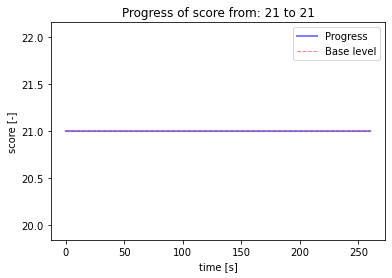

Genetic Progress: 0
Score from GA: 21
Climber progress: 0
Score after climbing: 21
Score after optimizing book distribution: 21. Progress: 0
Time elapsed: 280.0020115375519

File: b_read_on.txt
Greedy interval score:  5822900 time: 6.146183490753174


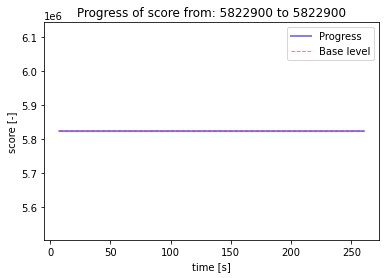

Genetic Progress: 0
Score from GA: 5822900
Climber progress: 0
Score after climbing: 5822900
Score after optimizing book distribution: 5822900. Progress: 0
Time elapsed: 280.63885164260864

File: c_incunabula.txt
Greedy interval score:  5687459 time: 13.100662231445312


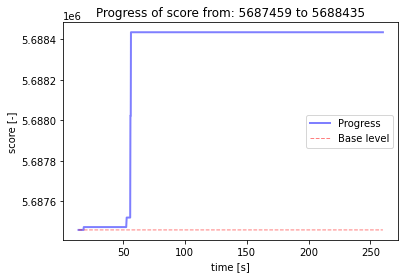

Genetic Progress: 976
Score from GA: 5688435
Climber progress: 0
Score after climbing: 5688435
Score after optimizing book distribution: 5688435. Progress: 0
Time elapsed: 280.3547029495239

File: d_tough_choices.txt
Greedy interval score:  4975360 time: 71.94074964523315


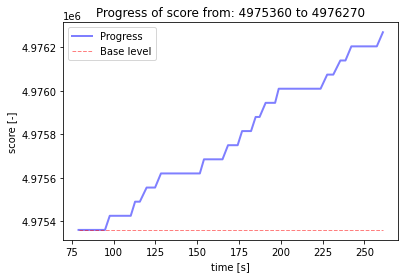

Genetic Progress: 910
Score from GA: 4976270
Climber progress: 130
Score after climbing: 4976400
Score after optimizing book distribution: 4976400. Progress: 130
Time elapsed: 281.7655248641968

File: e_so_many_books.txt
Greedy interval score:  5057067 time: 12.934185028076172


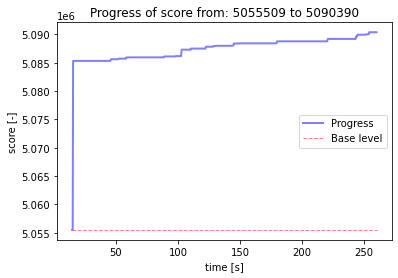

Genetic Progress: 34881
Score from GA: 5090390
Climber progress: 79
Score after climbing: 5090469
Score after optimizing book distribution: 5210401. Progress: 120011
Time elapsed: 280.70972299575806

File: f_libraries_of_the_world.txt
Greedy interval score:  5240157 time: 13.188772439956665


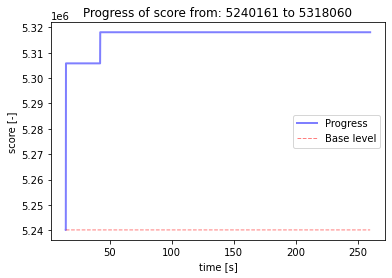

Genetic Progress: 77899
Score from GA: 5318060
Climber progress: 0
Score after climbing: 5318060
Score after optimizing book distribution: 5318060. Progress: 0
Time elapsed: 280.1358916759491

Sum of scores: 27016217


In [24]:
solve_with_flow_and_genetic_and_hill_climber(file_paths, 260, 280)

### Conclusions
In our opinion our algorithm performs pretty well. It always scores above 27mln in total. From previous graphs and our previous experiments it is clearly visible that good initial population (and that way good interval greedy/ heurystic algorithms) is the key to succes. Our genetic algorithm gives us more or less +0.1mln in the total score. What surprised us is that hill climbing algorithm barely improves results in most cases. That is why we decided to give it just 20s of the enterity of available time. However, when processing example g it gives us better results per unit of time than genetic algorithm, and that is why we decided to keep it. While for most cases our max flow min cost optimization does not improve results at all, it gives us around 0.1-0.15 mln improve in score, so it was definately a very good decision to use it.

### Sources
During developing our algorithm we uses and developed ideas contained in the following articles:
* https://medium.com/@achille.nazaret/hashcode-2020-1e1ef62e1229
* https://medium.com/better-programming/google-hash-code-2020-how-we-took-98-5-of-the-best-score-e5b6fa4abc1b
* https://towardsdatascience.com/google-hash-code-2020-a-greedy-approach-2dd4587b6033

Link to ORTools:

https://developers.google.com/optimization